# Recap notebook

In [1]:
library('rethinking')

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Loading required package: parallel

rethinking (Version 2.13)


Attaching package: ‘rethinking’


The following object is masked from ‘package:stats’:

    rstudent




In [18]:
mc.cores = parallel::detectCores()

In [20]:
rstan_options(auto_write = TRUE)

In [5]:
sppnames <- c("afarensis", "africanus", "habilis", "boisei", "rudolfensis", "ergaster", "sapiens")
brainvolcc <- c(438, 452, 612, 521, 752, 871, 1350)
masskg <- c(37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5)
d <- data.frame(species=sppnames, brain=brainvolcc, mass=masskg)
d$mass_std <- standardize(d$mass)
d$brain_std <- d$brain/max(d$brain)

For the purpose of this recap, I use a simple linear model from chapter 7.

In [6]:
m7.1 <- quap(
    alist(
    brain_std ~ dnorm(mu, exp(log_sigma)),
    mu <- a + b*mass_std,
    a ~ dnorm(0.5, 1),
    b ~ dnorm(0, 10),
    log_sigma ~ dnorm(0, 1)), data=d
)

## Important functions and concepts explained

### Sampling the posterior with `extract.samples()`
With extract.samples() you can sample values for the parameters from their posterior distribution.

In [110]:
post <- extract.samples(m7.1, n=1e3)

Each row in the dataframe is one sampled parameter distribution. 

In [83]:
head(post)

,a,b,log_sigma
,<dbl>,<dbl>,<dbl>
1,0.4640862,0.2375755,-1.850975
2,0.5334966,0.2302122,-1.929808
3,0.5085709,0.1169905,-2.053386
4,0.5810100,0.2894338,-1.759758
5,0.4927579,0.1588577,-1.805092
6,0.5165784,0.1910252,-1.471050


Summarizing the parameters' posterior distributions:

In [112]:
precis(post)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
a,0.5301451,0.06754835,0.42179680,0.6348941,▁▁▂▅▇▅▂▁▁
b,0.1670602,0.07491524,0.05373125,0.2925893,▁▁▁▃▇▇▅▂▁▁▁
log_sigma,-1.7126451,0.30368830,-2.19035090,-1.2200039,▁▁▁▁▃▅▇▇▂▁▁▁


Plotting posterior means and compatibility intervals:

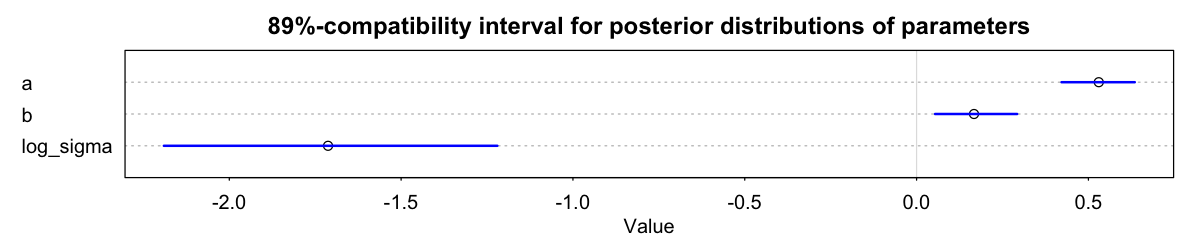

In [111]:
options(repr.plot.width=10, repr.plot.height=2)
plot(precis(post,2) , col.ci="blue", main="89%-compatibility interval for posterior distributions of parameters")

Plotting posterior probability density functions:

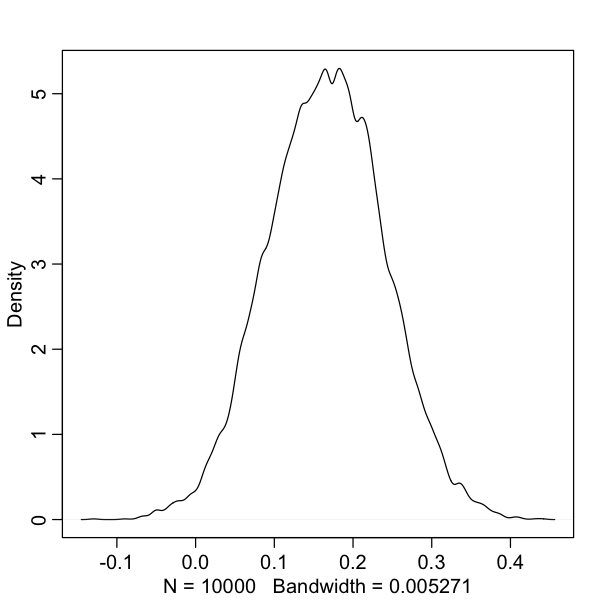

In [39]:
options(repr.plot.width=5, repr.plot.height=5)
dens(post$b)

Plotting the samples provides many possible regression lines.

In [150]:
plot_sample <- function(post, d, title){
    plot(
        brain_std~mass_std, 
        data=d, 
        main=title, 
        xlim=range(d$mass_std),
        ylim=c(0,1), 
        xlab="mass",
        ylab="brain"
    )

    for (i in 1:nrow(post)) curve(post$a[i]+post$b[i]*(x),
          from=min(mass),
          to=max(mass),
          add=TRUE,
          col=col.alpha("black", 0.025))
}

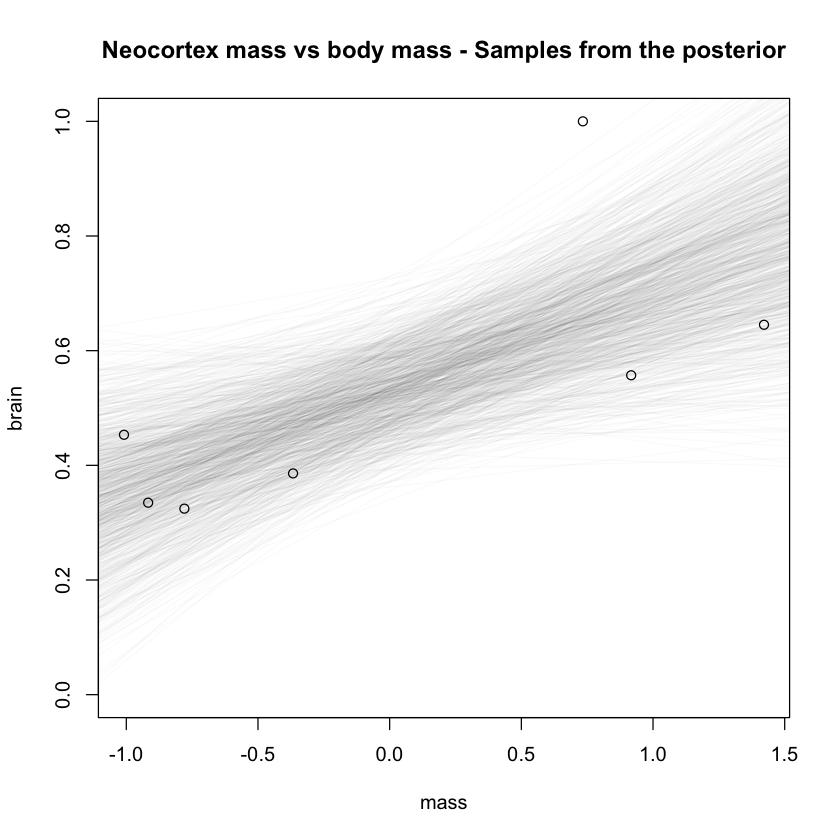

In [151]:
options(repr.plot.width=7, repr.plot.height=7)
plot_sample(post, d, "Neocortex mass vs body mass - Samples from the posterior")

When asked to compute a point estimate for a specific posterior distribution, we need to choose between either of the three provided below. In order to choose the one that is right for us in a specific case, we have to consider the cost associated with choosing either of the points (see book p.59)

**Maximum A Priori probability estimate (MAP):** This is the parameter value with the highest posterior probability, eg. the mode.  
**Posterior mean**: Minimizes quadratic loss (d-p)^2  
**Posterior median**: Minimizes absolute loss such that half of the probability mass is left and right to the value.

In cases where the posterior distribution is normally shaped and not or only slightly skewed, mean and median converge to the same value.

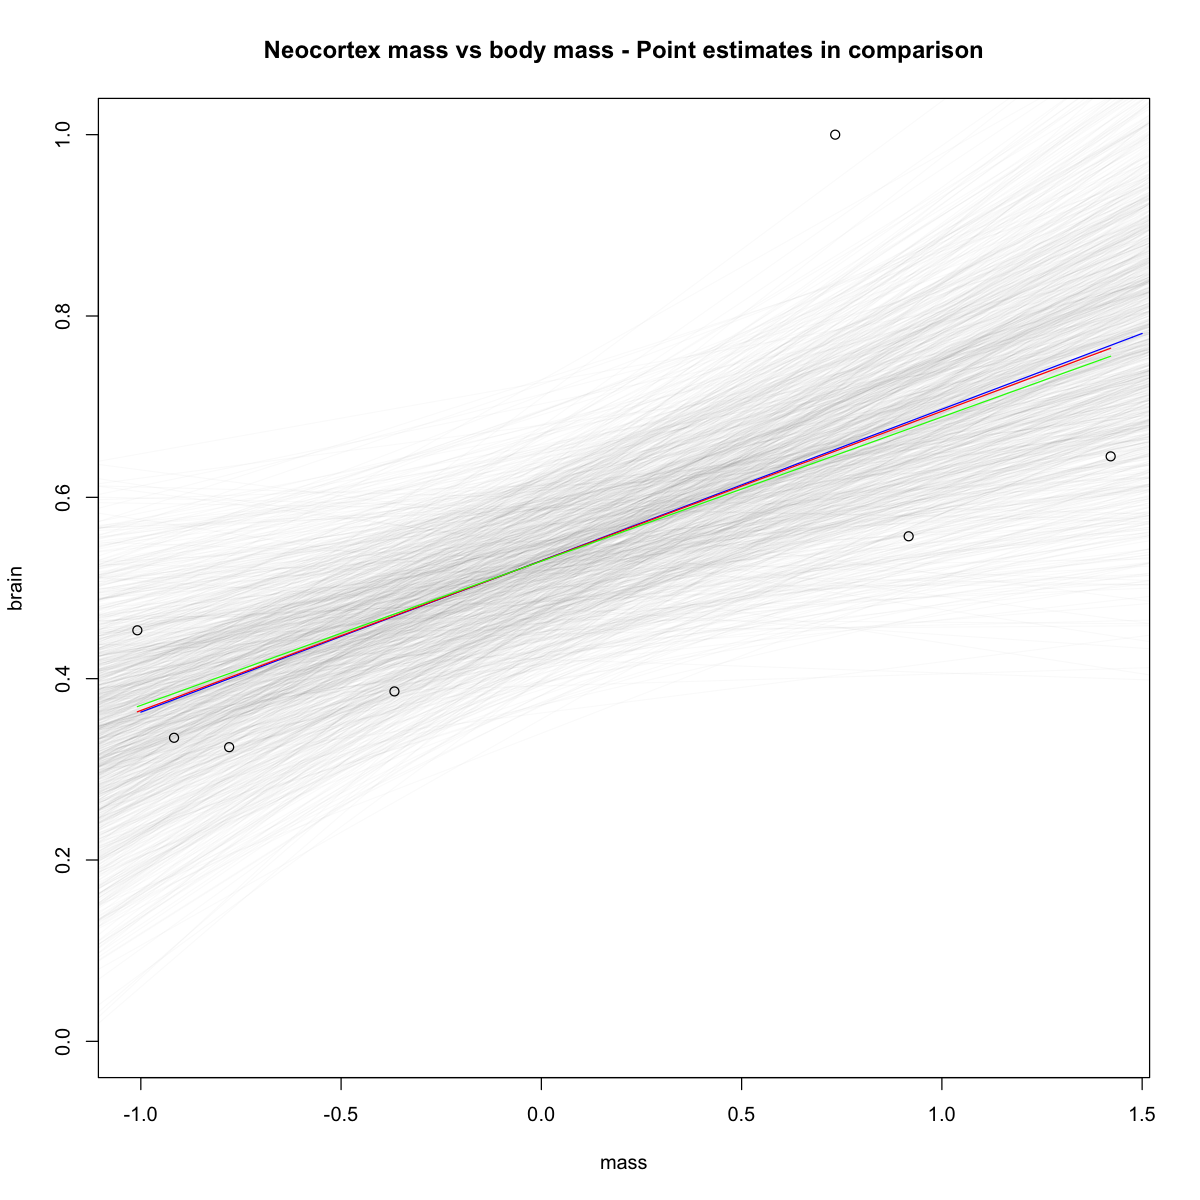

In [152]:
options(repr.plot.width=10, repr.plot.height=10)

plot_sample(post, d, "Neocortex mass vs body mass - Point estimates in comparison")
a_mean <- mean(post$a)
b_mean <- mean(post$b)
curve(a_mean+b_mean*(x), from=-1, to=1.5, col="blue", add=TRUE)

a_median <- median(post$a)
b_median <- median(post$b)
curve(a_median + b_median*x, add=TRUE, col='red')

a_mode <- chainmode(post$a)
b_mode <- chainmode(post$b)
curve(a_mode + b_mode*x, add=TRUE, col='green')

Obviously, **mean, mode and median produce quite similar results in this case.** However, loss functions for point estimates **may assume other forms as well that is very specific to the characteristics of the context in which the model is applied.** For example, if one is to predict wind speeds and the output of the model informs the decision whether to make an evacuation or not, then cost (in the form of casualties or destruction) will rise sharply from a certain point when wind speeds increase further while they may hardly change before that point. So the cost with picking an estimate increases heavily when one tends to underestimate the true wind speeds especially around that pivot point. Compared to mean and median estimates, the point estimate calculated from a loss function that depicts that will be higher:

###  Predicting from models with `link()`

From the docs: *"This function computes the value of each linear model at each sample for each case in the data."* In other words, the function draws samples for the model parameters from the posterior distributions. Each sample constitutes one linear model so `link()` calculates its response at each input value.

In [81]:
mass_seq <- seq(-1, 1.5, length.out=30)
mu <- link(m7.1, data=data.frame(mass_std=mass_seq))

Each column of the result contains 1000 predictions for the posterior mean at each value of `mass_seq`

In [120]:
dim(mu)

[1] 1000   30

Let's plot those posterior means:

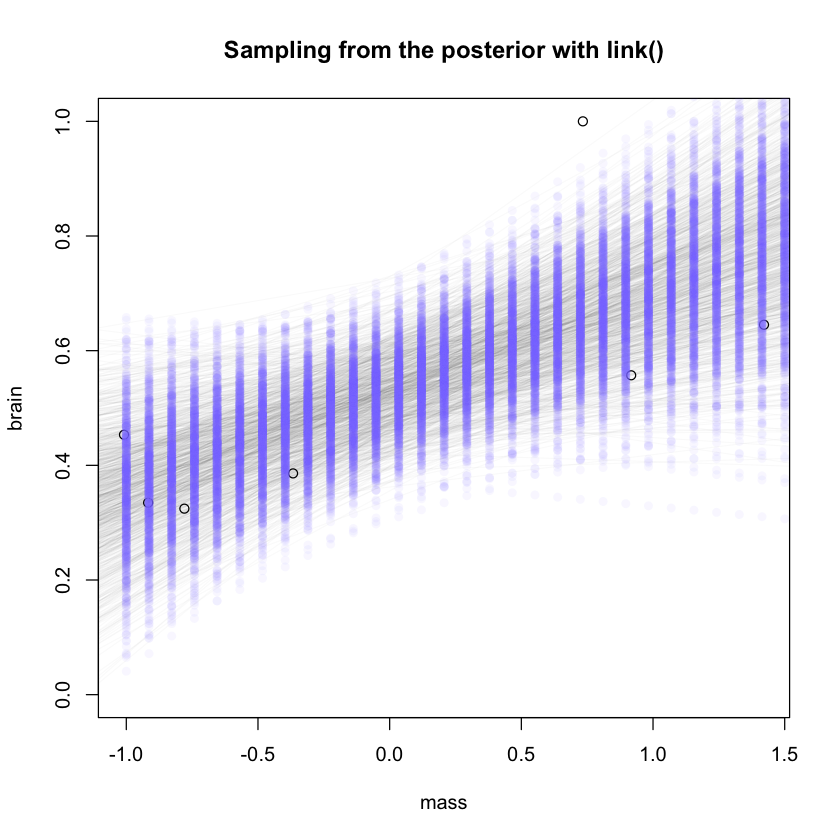

In [155]:
options(repr.plot.width=7, repr.plot.height=7)
plot_sample(post, d, "Sampling from the posterior with link()")
for (i in 1:1000)
  points( mass_seq, mu[i,], pch=16,col=col.alpha(rangi2,0.05))

Computing samples from the posterior with `extract.samples()` and plugging the parameters into the formula for mu is the steps that `link()` skips. The latter derives samples from the posterior for µ directly. Plotting the above points as lines results in a plot very similar to the one produced by `plot_sample()`.

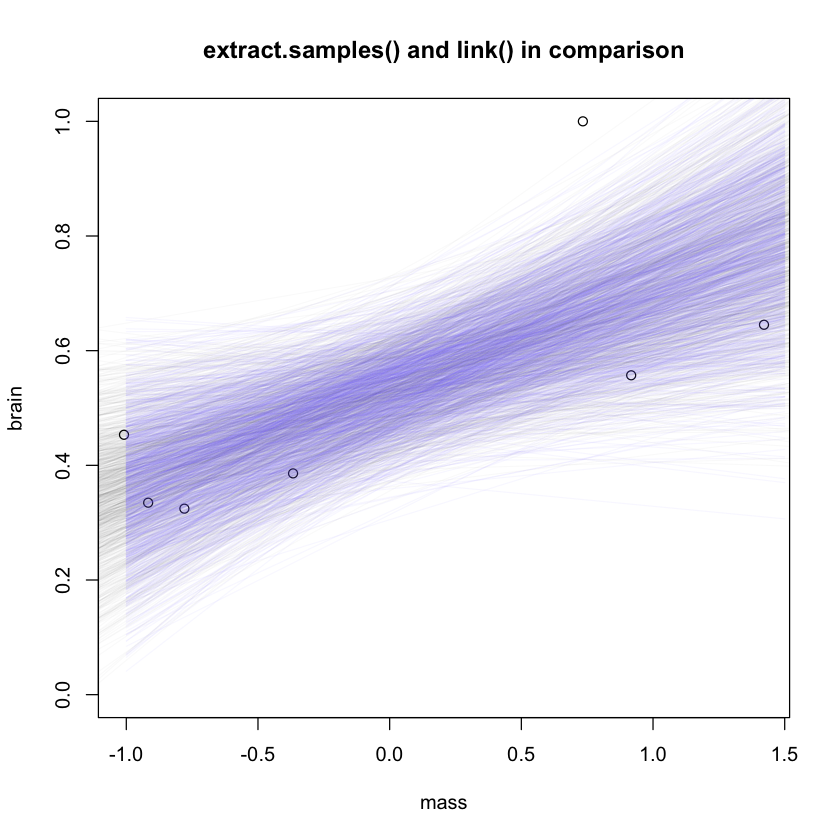

In [156]:
plot_sample(post, d, "extract.samples() and link() in comparison")
for (i in 1:1000)
  lines( mass_seq, mu[i,], pch=16,col=col.alpha(rangi2,0.05))

From the samples for mu, we can compute compatibility intervals:

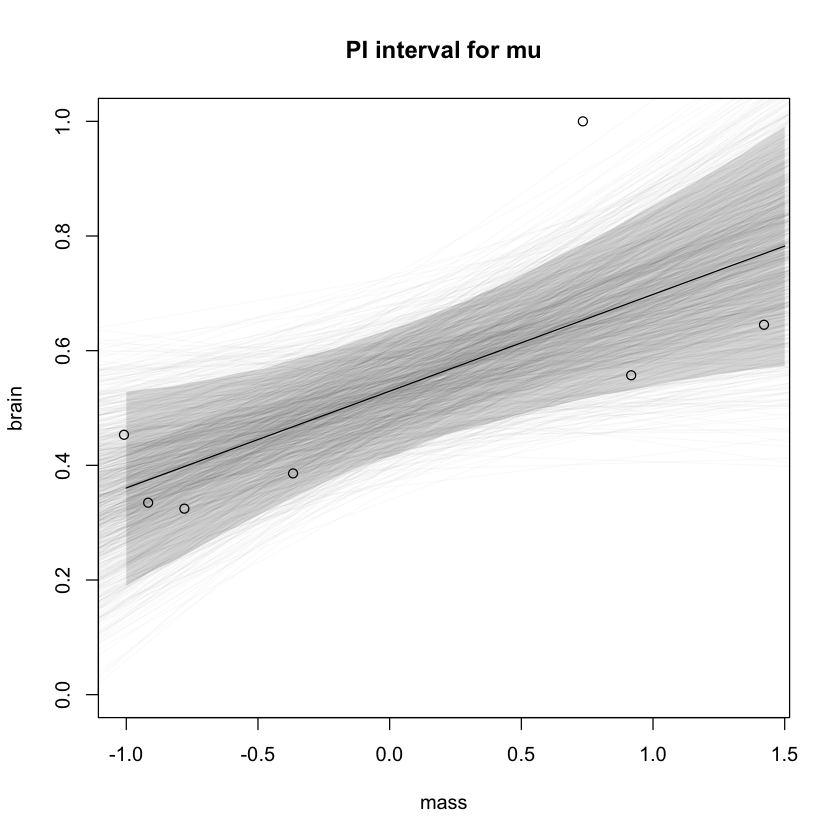

In [157]:
mu_PI <- apply(mu, 2, PI)
plot_sample(post, d, "PI interval for mu")
shade(mu_PI, mass_seq)
mu_mean <- apply(mu, 2, mean)
lines(mass_seq, mu_mean)

The compatibility interval for mu means that given the data and the priors the model expects mu to fall into this interval with 89% probability.

### Simulating posterior observations with `sim()`

Simulating posterior observations

In [144]:
sim_brain <- sim(m7.1, data=list(mass_std=mass_seq), n=1e3)

In [145]:
str(sim_brain)

 num [1:1000, 1:30] 0.602 0.101 0.594 0.469 0.414 ...


In [146]:
sim_brain_PI <- apply(sim_brain, 2, PI)

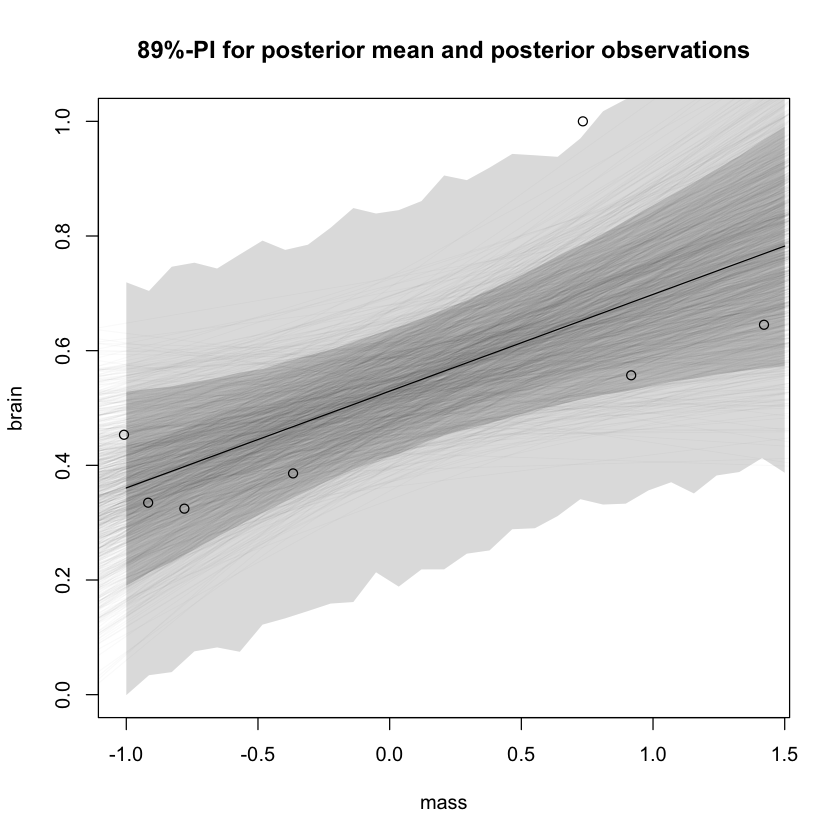

In [163]:
plot_sample(post, d, "89%-PI for posterior mean and posterior observations")
shade(sim_brain_PI, mass_seq)
shade(mu_PI, mass_seq)
lines(mass_seq, mu_mean)

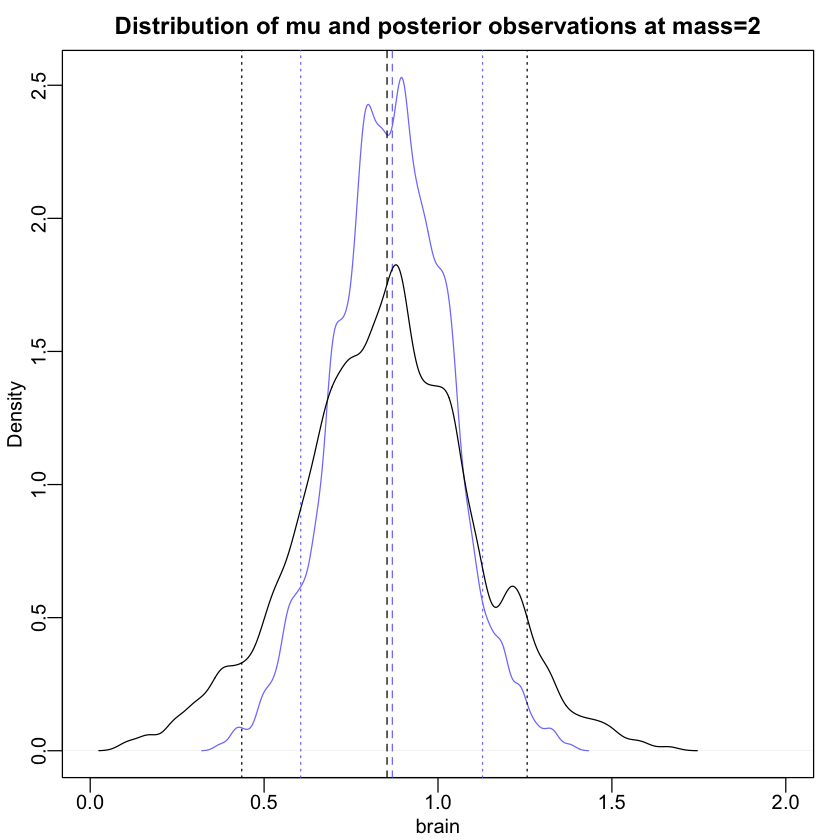

In [196]:
mu_single <- link(m7.1, data=data.frame(mass_std=c(2)))
dens(
    mu_single, 
    main="Distribution of mu and posterior observations at mass=2", 
    xlim=c(0, 2), 
    col=rangi2, 
    xlab='brain')
abline(v=mean(mu_single), lty=2, col=rangi2)
abline(v=PI(mu_single)[1], lty=3, col=rangi2)
abline(v=PI(mu_single)[2], lty=3, col=rangi2)

obs_single <- sim(m7.1, data=data.frame(mass_std=c(2)))
dens(obs_single, add=TRUE)
abline(v=mean(obs_single), lty=2)
abline(v=PI(obs_single)[1], lty=3)
abline(v=PI(obs_single)[2], lty=3)